# Initial Imports

In [135]:
import pandas as pd
import numpy as np
from nltk import ngrams
from wordcloud import WordCloud
import spacy
from spacy import displacy
from collections import Counter
import matplotlib.pyplot as plt
import plotly.express as px
from PIL import Image
from wordcloud import ImageColorGenerator
pd.options.plotting.backend = 'hvplot'

# Custom .py files
from get_lyric_data import get_lyrics
from get_chart_data import get_chart_genre
from text_processor import process_text
from get_lyrics_sentiment import lyrics_sentiment

# Lyric Data

### Search for top songs in GENRE

In [2]:
""" SHAZAM CORE API REQUEST """
""" WORLD CHART BY GENRE ENDPOINT """

# Use 'World Chart By Genre' endpoint to retrieve chart for a single genre

# GENRE CODES
# POP,HIP_HOP_RAP,DANCE,ELECTRONIC,SOUL_RNB,ALTERNATIVE,ROCK,LATIN,FILM_TV,COUNTRY,
# AFRO_BEATS,WORLDWIDE,REGGAE_DANCE_HALL,HOUSE,K_POP,FRENCH_POP,SINGER_SONGWRITER,REG_MEXICO

genre = 'COUNTRY'
limit_songs = 50

querystring = {"genre_code": genre,"limit":limit_songs}
chart_response = get_chart_genre(querystring)

In [3]:
# Retrieve Track IDs

track_ids=[] # song identifier
titles = [] # song name
subtitles = [] # Main artist and featured artists

for track in range(len(chart_response)):
    track_ids.append(chart_response[track]['id'])
    titles.append(chart_response[track]['title'])
    subtitles.append(chart_response[track]['subtitle'])

print(f"The number of songs retrieved is : {len(track_ids)}")

chart_songs = pd.DataFrame({"Track Name": titles, "Artists": subtitles, 'TrackIDs': track_ids}).set_index('TrackIDs')
chart_songs.head(5)


The number of songs retrieved is : 50


,Track Name,Artists
TrackIDs,,
595243928,The Cowboy In Me (Yellowstone Edition),Tim McGraw
54640449,Jingle Bell Rock,Bobby Helms
568180108,Fancy Like,Walker Hayes
52815945,Enchanted,Taylor Swift
463807349,Old Town Road (Remix),Lil Nas X Feat. Billy Ray Cyrus


In [550]:
# Take a look at the data

from collections import Counter

artists_list = list(chart_songs.Artists)
artist_counts = {artist: artists_list.count(artist) for artist in artists_list} #dict with frequency of artist in top chart

artists_df = pd.DataFrame(list(artist_counts.items()),columns = ['Artists','No. Songs in Top Chart']).set_index('Artists')
artists_df.sort_values(by = 'No. Songs in Top Chart', ascending=False, inplace=True) #sort values

# Plot artists frequency in top chart
genre_plot = artists_df.plot.bar(rot=45, width = 1000, height = 600, color = 'yellow', title = f'Top Artists on {genre} Chart')
genre_plot

:Bars   [Artists]   (No. Songs in Top Chart)

In [551]:
# Top 5 artists
artists_df.iloc[:5]

,No. Songs in Top Chart
Artists,
Taylor Swift,3
Luke Combs,3
Walker Hayes,2
Shania Twain,2
Chris Stapleton,2


### Search lyrics by TRACK

In [5]:
""" SHAZAM CORE API REQUEST """
""" TRACK DETAILS ENDPOINT """

# Retrieve Lyrics for all TrackIDs

track_ids  # the list created in "Search for top songs in Genre" section is required

lyrics=[]

for trackID in track_ids:
    querystring = {"track_id":trackID}
    track_details_response = get_lyrics(querystring)

    if track_details_response['sections'][1]['type'] != "LYRICS":  # Note: tracks with a type != "LYRICS" don't contain lyrics
        lyrics.append([''])
    else:
        track_lyrics = track_details_response['sections'][1]['text']
        lyrics.append(track_lyrics)

### Generate Lyrics DataFrame

In [6]:
# Add lyrics column to dataframe with chart songs

all_lyrics = pd.Series(" ".join(map(str,song)) for song in lyrics) #each song is stored as a list, this turns each list into a string
all_lyrics_df = pd.DataFrame({"Lyrics": all_lyrics, "Track IDs": track_ids}).set_index('Track IDs')

lyrics_df = pd.concat([chart_songs, all_lyrics_df], axis=1)
lyrics_df.head(5)

,Track Name,Artists,Lyrics
595243928,The Cowboy In Me (Yellowstone Edition),Tim McGraw,
54640449,Jingle Bell Rock,Bobby Helms,"Jingle bell, jingle bell, jingle bell rock Jin..."
568180108,Fancy Like,Walker Hayes,Ayy My girl is bangin' She's so low maintenanc...
52815945,Enchanted,Taylor Swift,"There I was again tonight Forcing laughter, fa..."
463807349,Old Town Road (Remix),Lil Nas X Feat. Billy Ray Cyrus,"Oh, oh-oh Oh Yeah, I'm gon' take my horse to ..."


In [7]:
# Remove songs without lyrics

lyrics_df.drop(lyrics_df.loc[lyrics_df['Lyrics'] == ''].index.tolist(), inplace=True)
lyrics_df.head(5)

,Track Name,Artists,Lyrics
54640449,Jingle Bell Rock,Bobby Helms,"Jingle bell, jingle bell, jingle bell rock Jin..."
568180108,Fancy Like,Walker Hayes,Ayy My girl is bangin' She's so low maintenanc...
52815945,Enchanted,Taylor Swift,"There I was again tonight Forcing laughter, fa..."
463807349,Old Town Road (Remix),Lil Nas X Feat. Billy Ray Cyrus,"Oh, oh-oh Oh Yeah, I'm gon' take my horse to ..."
559530353,Thinking 'Bout You,Dustin Lynch Feat. MacKenzie Porter,"Well, look who it is Last call I thought I'd g..."


In [8]:
# Find frequency of specific word
lyrics_df['Lyrics'].str.count('oh').sum()

134

### Export lyrics to a single .txt file

In [9]:
# Export lyrics to .txt file

text = ' '.join(lyrics_df['Lyrics'].tolist())

file = open('country_text.txt', 'w')
file.write(text)

print(text[:1000])

Jingle bell, jingle bell, jingle bell rock Jingle bells swing and jingle bells ring Snowing and blowing up bushels of fun Now the jingle hop has begun  Jingle bell, jingle bell, jingle bell rock Jingle bells chime in jingle bell time Dancing and prancing in Jingle Bell Square In the frosty air  What a bright time, it's the right time To rock the night away Jingle bell time is a swell time To go riding in a one-horse sleigh  Giddy-up jingle horse, pick up your feet Jingle around the clock Mix and a-mingle in the jingling beat That's the jingle bell rock  Jingle bell, jingle bell, jingle bell rock Jingle bells chime in jingle bell time Dancing and prancing in Jingle Bell Square In the frosty air  What a bright time, it's the right time To rock the night away Jingle bell time is a swell time To go riding in a one-horse sleigh  Giddy-up jingle horse, pick up your feet Jingle around the clock Mix and a-mingle in the jingling beat That's the jingle bell That's the jingle bell That's the jing

# Sentiment Analysis

In [44]:
# Use custom function lyrics_sentiment to analyze text with VADER

scores = lyrics_sentiment(lyrics_df)
sentiments_df = pd.concat([lyrics_df, scores], axis=1, join='inner')
sentiments_df.head()

,Track Name,Artists,Lyrics,Tokens,compound,positive,negative,neutral
54640449,Jingle Bell Rock,Bobby Helms,"Jingle bell, jingle bell, jingle bell rock Jin...","[rock, swing, ring, snowing, blowing, bushel, ...",0.8442,0.049,0.000,0.951
568180108,Fancy Like,Walker Hayes,Ayy My girl is bangin' She's so low maintenanc...,"[ayy, girl, bangin, shes, low, maintenance, ne...",0.9986,0.238,0.020,0.742
52815945,Enchanted,Taylor Swift,"There I was again tonight Forcing laughter, fa...","[tonight, forcing, laughter, faking, smile, ol...",0.9954,0.186,0.036,0.778
463807349,Old Town Road (Remix),Lil Nas X Feat. Billy Ray Cyrus,"Oh, oh-oh Oh Yeah, I'm gon' take my horse to ...","[yeah, take, horse, old, town, road, ride, til...",0.9643,0.110,0.020,0.871
559530353,Thinking 'Bout You,Dustin Lynch Feat. MacKenzie Porter,"Well, look who it is Last call I thought I'd g...","[well, look, last, call, thought, hows, mama, ...",0.8941,0.059,0.015,0.925


In [63]:
# Compute overall score for each track based on compound score

def overall_sentiment(score):

    """ Calculates the overall sentiment based on the compound score """

    result = 0  # Neutral by default
    if score >= 0.05:  # Positive
        result = 1
    elif score <= -0.05:  # Negative
        result = -1

    return result

sentiments_df['overall'] = sentiments_df['compound'].apply(lambda score: overall_sentiment(score))
sentiments_df.sample(5)

,Track Name,Artists,Lyrics,Tokens,compound,positive,negative,neutral,overall
595689118,All the Mountains Are High,Zé da Timba e Zé Latinha,All the mountains are high And the clouds make...,"[mountain, high, cloud, make, feel, safe, moun...",0.9637,0.206,0.016,0.778,1
559530353,Thinking 'Bout You,Dustin Lynch Feat. MacKenzie Porter,"Well, look who it is Last call I thought I'd g...","[well, look, last, call, thought, hows, mama, ...",0.8941,0.059,0.015,0.925,1
265721100,Sleeping On The Blacktop,Colter Wall,Sunshine beating on the good times Moonlight r...,"[sunshine, beating, good, time, moonlight, rai...",-0.6769,0.051,0.074,0.875,-1
248456076,Tennessee Whiskey,Chris Stapleton,Used to spend my nights out in a bar room Liqu...,"[used, spend, night, bar, room, liquor, love, ...",0.9957,0.257,0.012,0.731,1
566885142,Buy Dirt [Acoustic],Jordan Davis Feat. Luke Bryan,Few days before he turned 80 He was sitting ou...,"[day, turned, sitting, back, rocker, lately, t...",-0.7437,0.082,0.097,0.821,-1


In [327]:
# Plot overall sentiment scores for genre

positives = sentiments_df['overall'].loc[sentiments_df['overall'] == 1 ].count()
negatives = sentiments_df['overall'].loc[sentiments_df['overall'] == -1 ].count()
index_names = ['Positive', 'Negative']

overall = pd.DataFrame([positives,negatives], columns = ['Count'])
overall.index = index_names

country_sentiment_pie = px.pie(
    overall, 
    values = 'Count', 
    names=index_names, 
    hole = 0.4, 
    color_discrete_sequence=["yellow", "orange"], 
    width=500, 
    title=f'Overall Sentiment for {genre} Song Lyrics'
    )  
country_sentiment_pie

# Natural Language Processing

### Tokenizer

In [17]:
# Create a list of stopwords
sw_custom = {'wouldnt','got', 'get','would','ohoh','ooh', 'oh','youll','wan','tell', 'see','wouldn','didnt', 'there', 'theres','said', 'youve', 'wa', 'dont', 'cant', 'oh','ive', 'ill', 'na', 'youre', 'gon', 'im', 'go', 'id', 'say', 'aint', 'oh', 'jingle', 'bell', 'santa', 'claus'}

# Run the text_processor function for lyrics dataframe
lyrics_tokenized = [process_text(text, sw_custom) for text in lyrics_df['Lyrics']]

# Create a new tokens column for dataframe
lyrics_df['Tokens'] = lyrics_tokenized
lyrics_df.head(3)

,Track Name,Artists,Lyrics,Tokens
54640449,Jingle Bell Rock,Bobby Helms,"Jingle bell, jingle bell, jingle bell rock Jin...","[rock, swing, ring, snowing, blowing, bushel, ..."
568180108,Fancy Like,Walker Hayes,Ayy My girl is bangin' She's so low maintenanc...,"[ayy, girl, bangin, shes, low, maintenance, ne..."
52815945,Enchanted,Taylor Swift,"There I was again tonight Forcing laughter, fa...","[tonight, forcing, laughter, faking, smile, ol..."


### N-Grams and Frequency Analyzer

In [14]:
# Function bigrams_counter retrieves bigrams in a list of texts

def bigrams_counter(texts, n_results, sw_custom): 
    # Combine all articles in corpus into one large string
    big_string = ' '.join(texts)
    processed = process_text(big_string, sw_custom)
    bigrams = ngrams(processed, n=2)
    top = dict(Counter(bigrams).most_common(n_results))
    return pd.DataFrame(list(top.items()), columns=['Bigram', 'Count']).set_index('Bigram')

In [18]:
# Generate the N-grams where N=2
bigrams_counter(lyrics_df['Lyrics'], 10, sw_custom)

,Count
Bigram,
"(good, time)",23
"(still, one)",20
"(trouble, trouble)",19
"(pretty, woman)",16
"(thinking, bout)",12
"(probably, leave)",12
"(hey, darlin)",12
"(tryna, catch)",12
"(catch, good)",12


In [557]:
# Frequency Analysis

# Function token_count generates the top N words for given text
def token_count(tokens, n_results):
    """ Returns the top N tokens """
    """ Requires a dataframe series as input"""
    big_string = ' '.join(map(str,tokens))
    processed = process_text(big_string, sw_custom)
    topN = dict(Counter(processed).most_common(n_results))
    return pd.DataFrame(list(topN.items()), columns=['Word', 'Count']).set_index('Word')

# Plot most common tokens
top_words = token_count(lyrics_df['Tokens'],50)
top_words.plot.bar(rot=90, width=1000, color='yellow', title =f'Top Words for {genre}')


:Bars   [Word]   (Count)

In [559]:
# Export genre top_words to csv
top_words.to_csv(f'../all_genres/{genre}_top_words.csv')

### Word Cloud

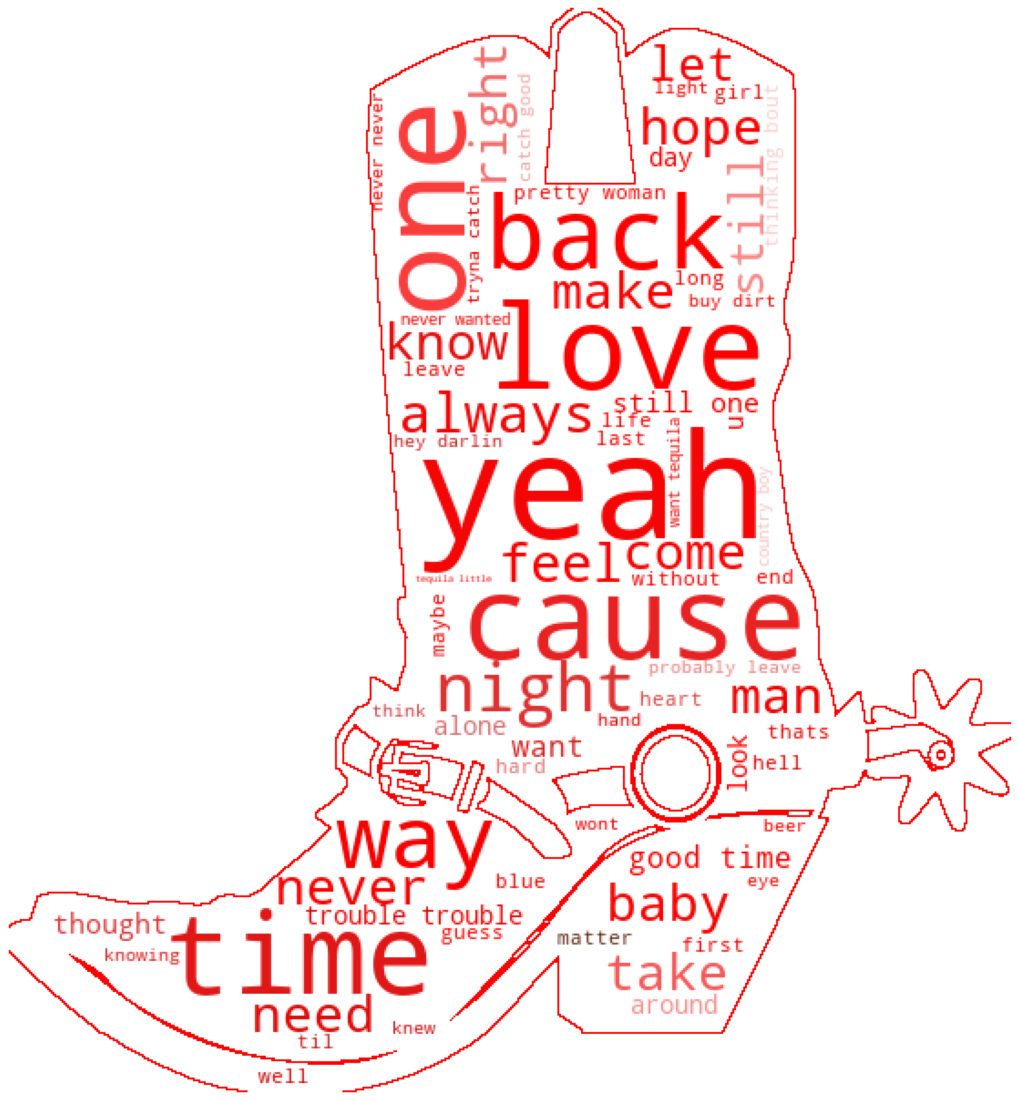

In [545]:
# Generate a word cloud image

# Text for word cloud

big_string = ' '.join(lyrics_df['Lyrics'])
lyrics_text = process_text(big_string, sw_custom)

# Add mask
mask = np.array(Image.open("images/cowboy-boot.png"))

# Create Word Cloud
wc_boot = WordCloud(contour_width=1, contour_color='red', width=2000, height=2000, background_color="white", max_words=70, mask=mask).generate(' '.join(lyrics_text))

# Create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(20,20))
plt.imshow(wc_boot.recolor(color_func=image_colors), interpolation="bilinear")

plt.axis("off")
plt.imshow(wc_boot)

# Save image as png
wc_boot.to_file("images/country.png")

# Name Entity Recognition

In [136]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

In [138]:
# Run the NER processor on all of the text

lyrics_text = ' '.join(lyrics_df["Lyrics"])
country_ner = nlp(lyrics_text)

# Add a title to the document
country_ner.user_data['title'] = 'Country NER'

In [445]:
# Render the visualization
# displacy.render(country_ner, style='ent')

In [512]:
# List all Entities

ent_labels=[]
entities=[]

for ent in country_ner.ents:
    ent_labels.append(ent.label_)
    entities.append(ent.text)

# Obtain frequency for each named entity

entities_freq = pd.DataFrame.from_dict([Counter(entities)]).T
entities_freq.columns = ['Frequency']
entities_freq.sort_values(by= 'Frequency', ascending=False, inplace = True)


# Retrieve labels for unique named entities

unique_nes = entities_freq.index.tolist()

labels = []

for word in unique_nes:
    idx = entities.index(word)
    label = ent_labels[idx]
    labels.append(label)

entities_freq['Label'] = labels

entities_freq


,Frequency,Label
Santa Claus,16,ORG
Tennessee,13,GPE
Mississippi,13,GPE
two,13,CARDINAL
one,11,CARDINAL
...,...,...
Kinda,1,GPE
Georgia,1,GPE
Playin,1,ORG
at least a million,1,CARDINAL


In [544]:
# Bar chart of frequencies of Named Entities

entities_count = pd.DataFrame.from_dict([Counter(ent_labels)]).T
entities_count.columns = ['Count']

entities_count.plot.bar(
    width=1000, 
    height = 400,
    color = 'yellow', 
    rot =45, 
    title = f'Top Named Entities found in {genre} Songs',
    hover_cols=['Count']
    )

:Bars   [index]   (Count)

In [560]:
# Export Entities dataframe to CSV
entities_count.to_csv(f'../all_genres/{genre}_entities_count.csv', index_label='Named_Entity')

# Next Word Prediction

Using Language Model Module (nltk.lm) from NLTK library

--Kneser-Ney Interpolated algorithm or MLE--